<a href="https://www.kaggle.com/code/karlpetz/starwars-lego-figures-computer-vision-model?scriptVersionId=105452006" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os 
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sys
from PIL import Image
sys.modules['Image'] = Image 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
base_dir = ""
names = ['Yoda', 'Luke', 'R2D2', 'Mace Windu', 'General Grevious']

tf.random.set_seed(1)

In [3]:
# if not os.path.isdir(base_dir + 'train'):
#     for name in names:
#         os.makedirs(base_dir + 'train\\' + name)
#         os.makedirs(base_dir + 'val\\' + name)
#         os.makedirs(base_dir + 'test\\' + name)
        

In [4]:
# orig_folders = ['0001\\','0002\\','0003\\','0004\\','0005\\']
# for folder_idx, folder in enumerate(orig_folders):
#     files = os.listdir(base_dir + folder)
#     number_of_images = len([name for name in files])
#     n_train = int((number_of_images *0.6) + 0.5)
#     n_valid = int((number_of_images * 0.25)+ 0.5)
#     n_test = number_of_images - n_train - n_valid
#     for idx, file in enumerate(files):
#         file_name = base_dir + folder + file
#         if idx < n_train:
#             shutil.move(file_name, base_dir + 'train\\' + names[folder_idx])
#         elif idx < n_train + n_valid:
#             shutil.move(file_name, base_dir + 'val\\' + names[folder_idx])
#         else:
#             shutil.move(file_name, base_dir + 'test\\' + names[folder_idx])
        
        

In [5]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2,zoom_range=0.2
    )
    
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [6]:
os.listdir('../input/starswars-lego-figures')


['val', 'test', 'train']

In [7]:
# for folder_idx, folder in enumerate(orig_folders):
#     print(folder, folder_idx)

In [8]:
train_batches = train_gen.flow_from_directory('../input/starswars-lego-figures/train',
    target_size = (256, 256),
    class_mode = 'sparse',
    batch_size = 4,
    shuffle = True,
    color_mode = 'rgb',
    classes=names
)
val_batches = valid_gen.flow_from_directory('../input/starswars-lego-figures/val',
    target_size = (256, 256),
    class_mode = 'sparse',
    batch_size = 4,
    shuffle = False,
    color_mode = 'rgb',
    classes=names
)
test_batches = test_gen.flow_from_directory('../input/starswars-lego-figures/test',
    target_size = (256, 256),
    class_mode = 'sparse',
    batch_size = 4,
    shuffle = False,
    color_mode = 'rgb',
    classes=names
)

Found 38 images belonging to 5 classes.
Found 17 images belonging to 5 classes.
Found 8 images belonging to 5 classes.


In [9]:
train_batches

In [10]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]

(4, 256, 256, 3)
[4. 1. 2. 3.]


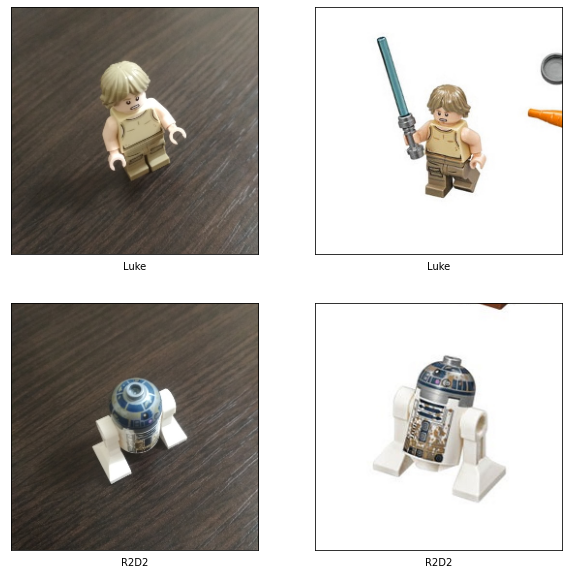

In [11]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()
    
show(test_batch)

In [12]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', padding='valid', input_shape=(256,256,3)))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=64,activation='relu'))
model.add(layers.Dense(units=5))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7872576   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

2022-09-12 03:44:13.008907: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']


model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [14]:
epochs = 100
# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=2
)

model.fit(train_batches, validation_data=val_batches,epochs=epochs, verbose=1,callbacks=[early_stopping])

2022-09-12 03:44:13.349690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
10/10 [==============================] - 2s 176ms/step - loss: 3.0673 - accuracy: 0.1842 - val_loss: 1.5927 - val_accuracy: 0.2353
Epoch 2/100
10/10 [==============================] - 2s 150ms/step - loss: 1.6542 - accuracy: 0.1842 - val_loss: 1.6071 - val_accuracy: 0.0588
Epoch 3/100
10/10 [==============================] - 2s 150ms/step - loss: 1.6093 - accuracy: 0.2368 - val_loss: 1.6058 - val_accuracy: 0.2941
Epoch 4/100
10/10 [==============================] - 2s 150ms/step - loss: 1.6028 - accuracy: 0.2632 - val_loss: 1.5869 - val_accuracy: 0.2941
Epoch 5/100
10/10 [==============================] - 2s 148ms/step - loss: 1.5943 - accuracy: 0.2895 - val_loss: 1.5927 - val_accuracy: 0.2353
Epoch 6/100
10/10 [==============================] - 2s 151ms/step - loss: 1.7317 - accuracy: 0.2105 - val_loss: 1.5876 - val_accuracy: 0.1765
Epoch 7/100
10/10 [==============================] - 2s 154ms/step - loss: 1.5997 - accuracy: 0.2632 - val_loss: 1.5619 - val_accuracy: 0.1765

In [15]:
history = model.history

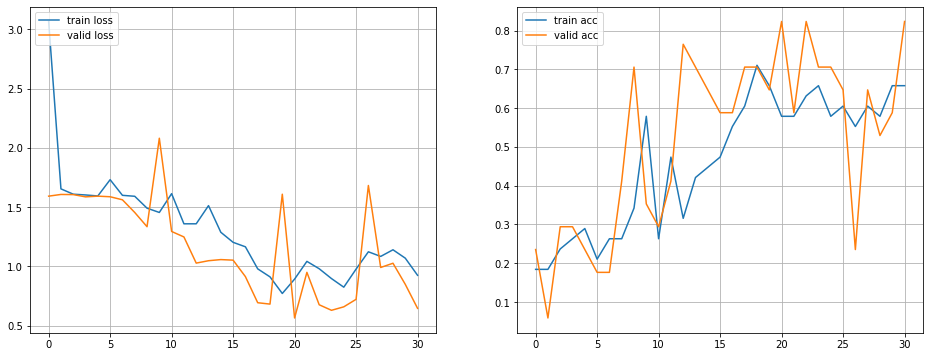

In [16]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'valid loss')
plt.legend(loc="upper left")
plt.grid()
         
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label = 'valid acc')
plt.legend(loc="upper left")
plt.grid()

In [17]:
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

[1. 1. 2. 2.]
[0 3 2 4]


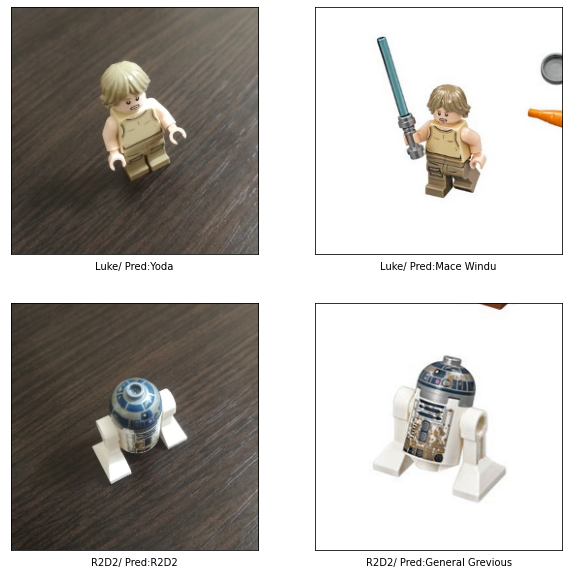

In [18]:
show(test_batches[0], labels[0:4])